In [1]:
from map_tool_box.modules import Environment
from map_tool_box.modules import Evaluator
from map_tool_box.modules import Rewarder
from map_tool_box.modules import Spawner
from map_tool_box.modules import Control
from map_tool_box.modules import Utils
from map_tool_box.modules import Astar
from IPython.display import HTML
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import os

# read configuration variables/objects from file

In [2]:
config_name = 'config_beta.py'
configs_directory = Utils.get_global('configs_directory')
config_in_path = Path(configs_directory, config_name)
%run $config_in_path

# set additional paramters for DRL

In [3]:
# if restricted on RAM set to true but will run slower
memory_saver = True
data_map.memory_saver = memory_saver

# file IO
models_directory = Utils.get_global('models_directory')
random_seed = 42
project_name = 'AirSim_Navigation'
experiment_name = 'DRL_beta'
#trial_name = f'seed_{random_seed}'
write_directory = Path(models_directory, project_name, experiment_name)#, trial_name) # write all results here
os.makedirs(write_directory, exist_ok=True)

# rewarder alpha vlaues (scale/weight)
goal_distance_alpha = -1 # weight how much progress an action takes towards goal (-) penalizes further away
step_alpha = -1 # (-) penalizes each step taken in an episode to encourage shorter paths
max_steps_alpha = -10 # (-) gives a large penalty at terminal step if not reached goal
goal_alpha = 40 # (+) gives a large reward at terminal step if reached goal

# evaluation parameters
# values are set extremely low for demonstration purposes -- typically they are much higher (see full in comment)
n_eval_paths = 1 # 100 full # number of paths to pull from curriculum dictionaries for each level for evaluations
burn_in = 1 # 50_000 full # initial number of episodes before starting to level up cirriculum learning
ckpt_freq = 1 # 10_000 full # write neural network weights and other learning loop state vars to file every this many episodes
level_up_freq = ckpt_freq # how many episodes until curriclulm level goes to next difficulty
eval_frequency = ckpt_freq # evaluate learning curve every eval_frequency episodes
max_episodes = 4 # 2_000_000 full # number of training episodes
difficulties = [i for i in range(2, 4)]

# write config.py file for future loading

In [4]:
config_out_path = Path(write_directory, 'config.py')
shutil.copy(config_in_path, config_out_path)

PosixPath('/home/tim/Dropbox/map_tool_box/models/AirSim_Navigation/DRL_beta/config.py')

# make DRL components and environment

In [5]:
# reward function -- found emperically to perform well
rewarders = [
    Rewarder.Step(step_alpha),
    Rewarder.GoalDistance(goal_distance_alpha),
    Rewarder.Goal(goal_alpha, goal_tolerance),
    Rewarder.MaxSteps(max_steps_alpha, steps_multiplier),
]

# curriculum learning paths -- astar difficulties split into train/val/test
# this will read all paths and spawn randomly during training
train_paths_train = Astar.read_curriculum(map_name, astar_version, 'train', difficulties=difficulties)
# this will read only n_eval_paths and spawn iteratively and exhaustively during evaluations
train_paths_eval = Astar.read_curriculum(map_name, astar_version, 'train', n_paths=n_eval_paths, difficulties=difficulties) # TODO add difficulties
val_paths_eval = Astar.read_curriculum(map_name, astar_version, 'val', n_paths=n_eval_paths, difficulties=difficulties)
test_paths_eval = Astar.read_curriculum(map_name, astar_version, 'test', n_paths=n_eval_paths, difficulties=difficulties)

# spawner -- decides how set starting and target positions on map
train_spawner_train = Spawner.CurricululmTrain(train_paths_train)
train_spawner_eval = Spawner.CurricululmEval(train_paths_eval)
val_spawner_eval = Spawner.CurricululmEval(val_paths_eval)
test_spawner_eval = Spawner.CurricululmEval(test_paths_eval)

# place holder (for SB3 we need to make environment before making model)
model = None

# evaluation methods -- do we do anything after each episode/step?
evaluation_environments = {
    'train':Environment.Episodic(data_map, train_spawner_eval, actor, observer, terminators),
    'val':Environment.Episodic(data_map, val_spawner_eval, actor, observer, terminators),
    'test':Environment.Episodic(data_map, test_spawner_eval, actor, observer, terminators),
}
evaluators = [
    Evaluator.Curriculum(difficulties, level_up_freq, burn_in), # levels up curriculum difficulty every n-episodes
    Evaluator.LearningCurve(evaluation_environments, model, eval_frequency, write_directory),  # evaluates on path sets every n-episodes
    Evaluator.MaxEpisodes(max_episodes),
]

# training environment -- primary source of everything RL (how do we step through an episode?)
starting_difficulty = difficulties[0]
train_environment = Environment.ReinforcementLearning(data_map, train_spawner_train, actor, observer, rewarders, terminators, 
                                                evaluators, starting_difficulty)

# make neural network action model (StableBaselines3 for now)

In [6]:
net_arch_layers = 3
net_arch_nodes = 64
total_policy_scale = 2
buffer_size = 1_000 # 100_000 full -- takes <50 gb memory
gamma = 0.99
device = 'cuda:0'
total_timesteps = 1_000_000_000 # we overwite the trigger for end of learning with episodes not steps
exploration_fraction = 0.1

from map_tool_box.modules import SB3Wrapper
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN as sb3Class

# sb3 wrappers
observer_sb3 = SB3Wrapper.SB3Observer(observer)
actor_sb3 = SB3Wrapper.SB3Actor(actor)
train_environment_sb3 = SB3Wrapper.SB3Environment(train_environment, observer_sb3, actor_sb3)

print('SB3 gym observation space:', train_environment_sb3.observation_space)
print('SB3 gym action space:', train_environment_sb3.action_space)

sb3_model_arguments = {
    'policy':'MultiInputPolicy',
    'env':train_environment_sb3,
    'buffer_size':buffer_size,
    'gamma':gamma,
    'device':device,
    'exploration_fraction':exploration_fraction,
    'policy_kwargs':{
        'net_arch':[int(total_policy_scale*net_arch_nodes) for _ in range(net_arch_layers)],
    },
}
sb3_model = sb3Class(**sb3_model_arguments)
model = SB3Wrapper.ModelSB3(sb3_model)

sb3_model.q_net

SB3 gym observation space: Dict('img': Box(0, 255, (3, 144, 256), uint8), 'vec': Box(0.0, 1.0, (12,), float32))
SB3 gym action space: Discrete(20)


QNetwork(
  (features_extractor): CombinedExtractor(
    (extractors): ModuleDict(
      (img): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=25088, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (vec): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (q_net): Sequential(
    (0): Linear(in_features=268, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=20, bias=True)
  )
)

# now set the model placeholder

In [7]:
# we need this evaluation component to have the model to play episodes
# this is hardcoded for the moment TODO improve this
evaluators[1].model = model

# step through one episode of envrionment with untrained model

In [8]:
# select which environment to evaluate
eval_environment = evaluation_environments['val']

# run through episode (view map_tool_box.modules.Environment.py to see what is saved in states)
states = Control.play_episode(eval_environment, model, save_additional_state_info=True, save_observations=True)

# make animation from episodic states
animation = eval_environment.animate_episode(states)

# show animation in notebook
display(HTML(animation.to_jshtml()))

# save as gif
#animation.save('episode.gif', writer='pillow', fps=2)

# Train RL Model (StableBaselines3)

In [9]:
# this is commented out for now -- just use the random initialized weights
# full training takes a day or two to run (this is an example notebook with the values dialed way back to finish in a few minutes)

# allow us to control when to terminate training from SB3 learn()
class StopLearning(BaseCallback):
    def __init__(self, train_environment_sb3, verbose: int = 0):
        super().__init__(verbose)
        self.environment = train_environment_sb3
    def _on_step(self) -> bool:
        return self.environment.continue_learning

# call sb3 learn method
callback = StopLearning(train_environment)
train_environment.start_learning()
sb3_model.learn(
    total_timesteps,
    callback = callback,
    log_interval = -1,
    tb_log_name = None,
    reset_num_timesteps = False,
)

# save to file
model_path = Path(write_directory, 'model.zip')
sb3_model.save(model_path)

2 ['train: 0.0', 'val: 0.0', 'test: 0.0']
4 ['train: 0.0', 'val: 0.0', 'test: 0.0']


# cheat and set learned weights from a previous training run (took 2 days)

In [10]:
import torch
state_dict_path = Path(write_directory, 'state_dict.pth')
state_dict = torch.load(state_dict_path, map_location=torch.device('cpu'))
sb3_model.q_net.load_state_dict(state_dict)
sb3_model.save(model_path)

# view learning curve from training

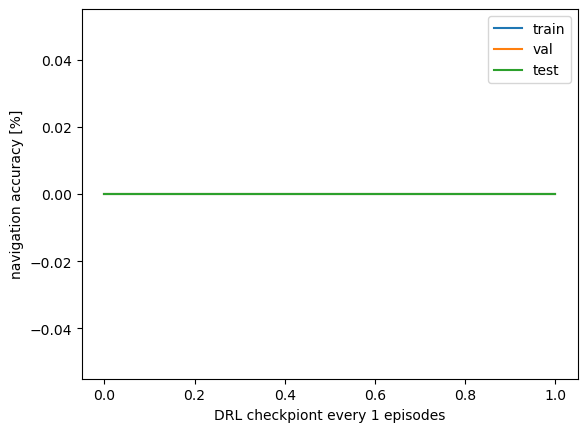

In [11]:
# this learning curve is a failed curve from a trial run
curve_path = Path(models_directory, project_name, experiment_name, 'learning_curve.p')
learning_curve = Utils.pickle_read(curve_path)
for key in learning_curve:
    plt.plot(np.array(learning_curve[key])*100, label=key)
plt.legend()
plt.xlabel(f'DRL checkpiont every {ckpt_freq} episodes')
plt.ylabel(f'navigation accuracy [%]')
plt.show()

# step through an episode with trained model

In [12]:
evaluation_environments['test'].spawner.reset()

In [13]:
# select which environment to evaluate
eval_environment = evaluation_environments['test']

# run through episode (view map_tool_box.modules.Environment.py to see what is saved in states)
states = Control.play_episode(eval_environment, model, save_additional_state_info=True, save_observations=True)

# make animation from episodic states
animation = eval_environment.animate_episode(states)

# show animation in notebook
display(HTML(animation.to_jshtml()))

# save as gif
#animation.save('episode.gif', writer='pillow', fps=2)